In [1]:
from pathlib import Path
from time import time
import datetime

import numpy as np
import pandas as pd

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
# Global Settings

# Directories
model_dataDir = 'DATA/MODELDATA/'
bench_dataDir = 'DATA/COINHISTDATA/'


# Time
START = 2020
END = 2022


# Helpers
sns.set_style('whitegrid')
np.random.seed(42)
idx = pd.IndexSlice


In [3]:
# Import Data

# Predictions
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')
lasso_predictions = pd.read_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')

# Prices
model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
model_mdf.set_index(['Dates', 'Coin'], inplace=True)
prices = model_mdf.loc[:,'Open':'Close']

# Benchmark
bench = pd.read_csv(bench_dataDir + 'bitcoin.csv')
bench.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
bench.set_index('Dates', inplace=True)
bench = bench.loc[:, ['Open']]
#bench = bench.Open
bench = bench.pct_change()
bstart = ridge_predictions.index.get_level_values('Dates').min().strftime('%Y-%m-%d')
bstop = (ridge_predictions.index.get_level_values('Dates').max() + pd.DateOffset(1)).strftime('%Y-%m-%d')
bench = bench[bstart:bstop]
bench.rename(columns = {'Open':'Bench'}, inplace = True)

In [4]:
#bench.info()

In [5]:
#bench.head()

In [6]:
def get_backtest_data(predictions, prices):
    """Combine regression model predictions
        with  OHLCV data"""
    
    best_alpha = predictions.groupby('alpha').apply(lambda x: spearmanr(x.actuals, x.predicted)[0]).idxmax()
    predictions = predictions[predictions.alpha == best_alpha]
    predictions.index.names = ['Dates', 'Coin']
    tickers = predictions.index.get_level_values('Coin').unique()
    
    
    start = predictions.index.get_level_values('Dates').min().strftime('%Y-%m-%d')
    stop = (predictions.index.get_level_values('Dates').max() + pd.DateOffset(1)).strftime('%Y-%m-%d')
    idx = pd.IndexSlice
    #prices = prices.sort_index().loc[idx[tickers, start:stop], :]
    predictions = predictions.loc[predictions.alpha == best_alpha, ['predicted']]
    
    #print(predictions.head())
    #print('-----------------')
    #print(prices.head())
    
    return predictions.join(prices, how='right')


data = get_backtest_data(lasso_predictions,prices)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30522 entries, (Timestamp('2020-01-01 00:00:00'), 'algorand') to (Timestamp('2022-01-14 00:00:00'), 'zcash')
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   predicted  26403 non-null  float64
 1   Open       30522 non-null  float64
 2   High       30522 non-null  float64
 3   Low        30522 non-null  float64
 4   Close      30522 non-null  float64
dtypes: float64(5)
memory usage: 2.3+ MB
None


In [7]:
data = data.swaplevel()
data.head()

predicted      Open      High       Low     Close
Coin     Dates                                                        
algorand 2020-01-01        NaN  0.218748  0.222235  0.216208  0.217082
         2020-01-02        NaN  0.217110  0.223550  0.212620  0.221130
         2020-01-03        NaN  0.225794  0.228268  0.223328  0.227190
         2020-01-04        NaN  0.228031  0.235819  0.227050  0.235536
         2020-01-05        NaN  0.234223  0.237087  0.229622  0.231797

In [8]:
# Daily returns for all the coins in the dataset for the target time period
daily_returns = data.Open.unstack('Coin').sort_index().pct_change()
daily_returns.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 745 entries, 2020-01-01 to 2022-01-14
Columns: 41 entries, algorand to zcash
dtypes: float64(41)
memory usage: 244.5 KB


In [9]:
#daily_returns.head()

In [10]:
# Compute forward returns
fwd_returns = daily_returns.shift(-1)
fwd_returns.head()

Coin,algorand,arweave,basic-attention-token,binancecoin,bitcoin,bitcoin-cash,bitcoin-cash-sv,bittorrent-2,cardano,chainlink,...,monero,okb,ripple,stellar,terra-luna,tezos,theta-token,tron,vechain,zcash
Dates,,,,,,,,,,,,,,,,,,,,,
2020-01-01,-0.007487,-0.191683,0.038381,-0.019385,-0.010226,-0.021659,-0.034036,-0.026084,-0.002644,-0.003675,...,0.009755,-0.012907,-0.009533,-0.006929,-0.113821,0.015208,-0.030449,-0.013572,-0.007578,0.001243
2020-01-02,0.039997,0.069659,-0.023249,0.004268,0.008102,0.009556,0.012755,0.009159,0.023980,-0.002170,...,0.058491,0.011297,-0.005260,0.006081,-0.058763,-0.058131,-0.001032,0.004843,-0.010237,-0.009523
2020-01-03,0.009908,-0.042665,0.003384,0.005184,0.017150,0.088763,0.084565,0.020615,0.005945,0.006337,...,0.043093,0.002632,0.010071,0.005176,0.134023,0.003537,0.038290,0.017998,0.017339,0.032221
2020-01-04,0.027151,-0.105852,0.020056,0.023591,0.017537,0.009251,0.057229,0.004651,0.020064,0.007063,...,0.012155,0.022693,0.014026,0.008137,0.032663,-0.007134,0.047304,0.019789,0.043063,0.074968
2020-01-05,-0.003570,0.208598,0.006838,0.029197,0.009590,0.057490,0.046149,0.018887,0.021067,0.018736,...,0.096867,0.012061,0.008780,0.013771,-0.019673,-0.000040,0.074717,0.015457,-0.011077,0.034756


In [11]:
# Isolate the predictions
predictions = data.predicted.unstack('Coin')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 745 entries, 2020-01-01 to 2022-01-14
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   algorand               644 non-null    float64
 1   arweave                644 non-null    float64
 2   basic-attention-token  644 non-null    float64
 3   binancecoin            644 non-null    float64
 4   bitcoin                644 non-null    float64
 5   bitcoin-cash           644 non-null    float64
 6   bitcoin-cash-sv        644 non-null    float64
 7   bittorrent-2           644 non-null    float64
 8   cardano                644 non-null    float64
 9   chainlink              644 non-null    float64
 10  cosmos                 644 non-null    float64
 11  crypto-com-chain       644 non-null    float64
 12  dash                   644 non-null    float64
 13  decentraland           644 non-null    float64
 14  dogecoin               644 non-null    

In [12]:
#predictions.head(50)

In [13]:
# VECTORIZED BACKTEST

# Set the number of long and short positions
N_LONG = N_SHORT = 20

# Get the trading signals from the model predictions
long_signals = ((predictions
                .where(predictions > 0)
                .rank(axis=1, ascending=False) > N_LONG)
                .astype(int))
short_signals = ((predictions
                  .where(predictions < 0)
                  .rank(axis=1) > N_SHORT)
                 .astype(int))


# Compute the portfolio returns for the backtest
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

In [14]:
#strategy.join(bench).head(100)

In [15]:
#bench.index.dtype

In [16]:
#bench.head(100)

In [17]:
#strategy.index.dtype

In [18]:
#strategy.head(100)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


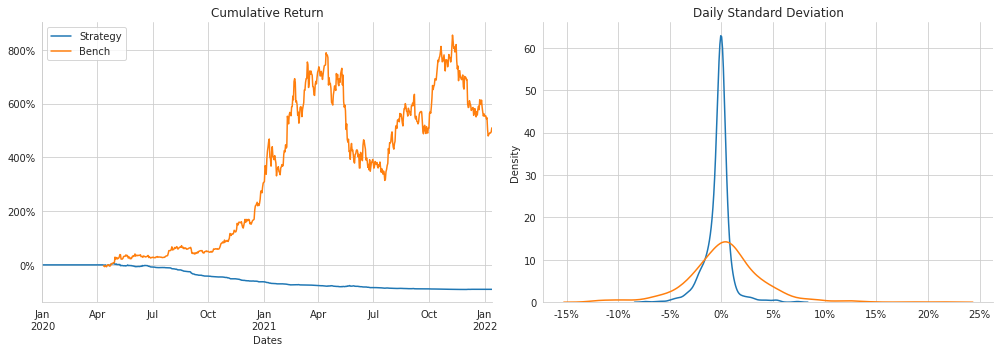

In [19]:
# Results
bench.index = pd.to_datetime(bench.index)
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(bench).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(bench, ax=axes[1], hist=False, label='BTC')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

In [ ]:
# EVENT-DRIVEN BACKTEST with Backtestester